# Imports

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torchsummary import summary
import pandas as pd
import json

# Preparation of Dataset

In [2]:
# Image transformations

image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
traindir = "~/fiftyone/caltech101_train"
validdir = "~/fiftyone/caltech101_valid"
testdir = "~/fiftyone/caltech101_test"

In [4]:
with open("../../../fiftyone/caltech101/info.json", 'r') as file:
    info = json.load(file)

classes = tuple(info['classes'])

In [5]:
BATCH_SIZE = 5

In [6]:
# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test']),
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'valid': DataLoader(data['valid'], batch_size=BATCH_SIZE, shuffle=True),
    'test': DataLoader(data['valid'], batch_size=BATCH_SIZE, shuffle=True)
}

# Sample Check

In [7]:
# Iterate through the dataloader once
image, label = next(iter(dataloaders['train']))
image.shape, label.shape

(torch.Size([5, 3, 224, 224]), torch.Size([5]))

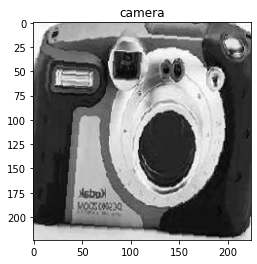

In [8]:
i = np.random.randint(0, 4)             # Choose one image at random
plt.imshow(image[i, 0], cmap='gray')    # Plot
plt.title(classes[label[i]]);

# Pretrained Model

In [9]:
model = models.vgg16(pretrained=True)

In [10]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [12]:
# classifier of the pretrained model
# --> I am changing the 6th layer (i.e. classifier[6])
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [13]:
# Pretrained model
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

# Modify the Last Layer of the Classifier

In [14]:
# Constants for Last Layer

n_inputs = 4096
n_classes = len(os.listdir("../../../fiftyone/caltech101_train/"))

In [15]:
n_classes

102

In [16]:
# Modify classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))

In [17]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,335,590 total parameters.
1,075,046 training parameters.


# Moving Model to GPU

In [19]:
# Move to gpu
model = model.to('cuda')

In [20]:
device = torch.device("cuda")

# Prediction Function and Prediction Check before Training

In [21]:
def plot_prediction(image, label, predictions):
    """Plot network predictions with matplotlib."""
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)  # Plot
    ax1.imshow(image[0], cmap='gray')
    ax1.axis('off')   
    ax1.set_title(classes[label])
    ax2.barh(np.arange(10), predictions.squeeze())
    ax2.set_title("Predictions")
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_xlim(0, 1)
    plt.tight_layout();

In [24]:
# Test on training images (run as many times as you like!)
image, label = next(iter(dataloaders["train"]))        # Get a random batch of 64 images
model.to(device)
image = image.to(device)
label = label.to(device)
predictions = model(image)  # Get first image and predict it
predictions = nn.Softmax(dim=1)(predictions)  # Coerce predictions to probabilities using Softmax()
predictions = torch.topk(predictions, 10)
predictions[0].detach().cpu()
# plot_prediction(image[0].cpu(), label[0].cpu(), predictions[0].detach().cpu())

tensor([[0.0256, 0.0237, 0.0201, 0.0188, 0.0172, 0.0166, 0.0166, 0.0158, 0.0153,
         0.0150],
        [0.0146, 0.0132, 0.0132, 0.0131, 0.0130, 0.0129, 0.0128, 0.0125, 0.0124,
         0.0124],
        [0.0235, 0.0167, 0.0155, 0.0152, 0.0148, 0.0146, 0.0146, 0.0145, 0.0139,
         0.0135],
        [0.0172, 0.0156, 0.0142, 0.0137, 0.0136, 0.0135, 0.0129, 0.0127, 0.0124,
         0.0123],
        [0.0189, 0.0146, 0.0142, 0.0142, 0.0142, 0.0136, 0.0135, 0.0134, 0.0131,
         0.0128]])

C:\Users\johnw\miniconda3\envs\575\lib\site-packages\numpy\lib\stride_tricks.py:537: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
C:\Users\johnw\miniconda3\envs\575\lib\site-packages\numpy\lib\stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (5,) and arg 3 with shape (10,).

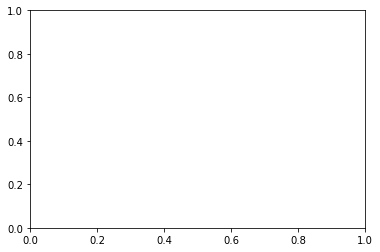

In [26]:
plt.barh(np.arange(10), predictions[0].detach().cpu())

In [ ]:
predictions.values.cpu().detach().numpy().squeeze()

# Training

In [ ]:
# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        train_batch_acc = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)  # forward pass to get output
            _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
            loss = criterion(y_hat, y)  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            train_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                X = X.to(device)
                y = y.to(device)
                y_hat = model(X)  # forward pass to get output
                _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}."
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
        
    print("\nTraining ended.")
    
    return train_loss, valid_loss, train_accuracy, valid_accuracy

In [ ]:
%%time

train_loss, valid_loss, train_accuracy, valid_accuracy = trainer(
    model, criterion, optimizer, dataloaders['train'], dataloaders['valid'], epochs=2, verbose=True
)

In [ ]:
loss_fig = pd.DataFrame(
    {"train_loss": train_loss, "valid_loss": valid_loss}
).plot.line()
loss_fig.set_xlabel('Epoch')
loss_fig.set_ylabel('Loss');

accur_fig = pd.DataFrame(
    {"train_accuracy": train_accuracy, 
     "valid_accuracy": valid_accuracy}
).plot.line()
accur_fig.set_xlabel('Epoch')
accur_fig.set_ylabel('Accuracy');